In [128]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [129]:
%config Completer.use_jedi = False

# Logistic Regression on  Amazon Fine food Review 
The Amazon fine food dataset consists of reviews of fine foods from amazon
All data in one sqlite database. 568,454 food reviews Amazon users left up to October 2012
Data includes:

* Number of reviews :  568,454 reviews
* Number of user : 256,059 users
* Total Number of Producst : 74,258 products
* Time Span of taking Reviews : from Oct 1999 - Oct 2012
* Number of Columns/fields : 10

***Attributes Information :***
1. Id : Row Id
1. ProductId :Unique identifier for the product (74258 unique values)
1. UserId :Unqiue identifier for the user (256059 unique values)
1. ProfileName : Profile name of the user (218418 unique values )
1. HelpfulnessNumerator : Number of users who found the review helpful 
1. HelpfulnessDenominator : Number of users who indicated whether they found the review helpful or not 
1. Score : Rating between 1 and 5
1. Time : Timestamp for the review
1. Summary : Brief summary of the review (295744 unique values)
1. Text : Text of the review (393579 unique values)

> **Objective :** *Given a review ,determine whether a review is postive or negative*

**Q].** *How to determine if a review is postive or negative?*

**Ans.** We can use the Score/rating. A rating of 4 or 5 could be considered as positive review & A rating of 1 or 2 can be consider as negative review . A rating of 3 can be consider as neutral and can be ignored . This is the approximation and proxy way to approach way of determing the polarity(positivity/negativity) of reviews.

# Loadig the data 
The dataset is available in two forms
1. .csv form
2. Sqlite Database

In order to load the database ,I have use the Sqlite Database as it easier to query the data and visualise the data sufficienlty . Here as we only want to get the global sentiment of the recommnedation(Positive/Negative), We will purposefully ignore all the scores equal to 3 ,If the Score is above 3 then the reviews will be "Positive",Otherwise it will "Negative".

# Importing important library

In [130]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#mterics 
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import roc_auc_score

import string
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

import os
import pickle 
from tqdm import tqdm


# Readind Data from Sqlite database

In [131]:
#Using the sqlite table to read data
con = sqlite3.connect('/Users/krithishetty/Downloads/finefoodreviews/database.sqlite')
# Filtering only Positive and Negative Reviews i.e not taking into consideration those reviews with score=3
filtered_data= pd.read_sql_query("""SELECT * FROM Reviews WHERE Score!=3""",con)
#Given reviews with score>3 a postive rating "1" and reviews with score <3 a negative "0"
#constucting a function
def partition(x):
    if x<3:
        return 0
    return 1
#Changing reviews with score<3 to be negative "0" and score > 3 to be positive "1"
actualscore=filtered_data['Score']
Positve_Negative=actualscore.map(partition)
filtered_data['Score']=Positve_Negative
print("No. of data points in Dataset:",filtered_data.shape)
filtered_data.head(3)


No. of data points in Dataset: (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# Exploratory Data Analysis

### Data Deduplication{The most important part of cleaning data}
It was observes that(as shown in table below) that the reviews data had many deduplicates entries .Hence it is neccessary to remove the deduplication in order to get unbaised results for the Analysis of the data.
Following is the example given below

In [132]:
display= pd.read_sql_query("""SELECT * FROM Reviews WHERE Score !=3 AND UserId ='AR5J8UI46CURR' ORDER BY ProductId """,con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


**As it can be seen above the same user has multiple reviews of the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)**

**ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on**

**It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.**

**The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product**

In [133]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values("ProductId",axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')
display.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [134]:
#Deduplication entries
final_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
final_data.shape

(364173, 10)

In [135]:
#Checking to see how much % of data still remains
print('The total data remain after cleaning data ',(final_data['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100)

The total data remain after cleaning data  69.25890143662969


In [136]:
final_data[final_data['HelpfulnessNumerator']>final_data['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,1,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,1,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [137]:
display=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score!=3 AND Id=44737 OR Id=64422
ORDER BY ProductID""",con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


**Observation:** It was seen that in 2 rows given above the value of HelpfullnessNumerator is Greater than HelpfullnessDenominator which is not practically hence such rows are too removed from dataset

In [138]:
final_data=final_data[final_data['HelpfulnessNumerator']<=final_data['HelpfulnessDenominator']]
final_data.shape

(364171, 10)

(364171, 10)


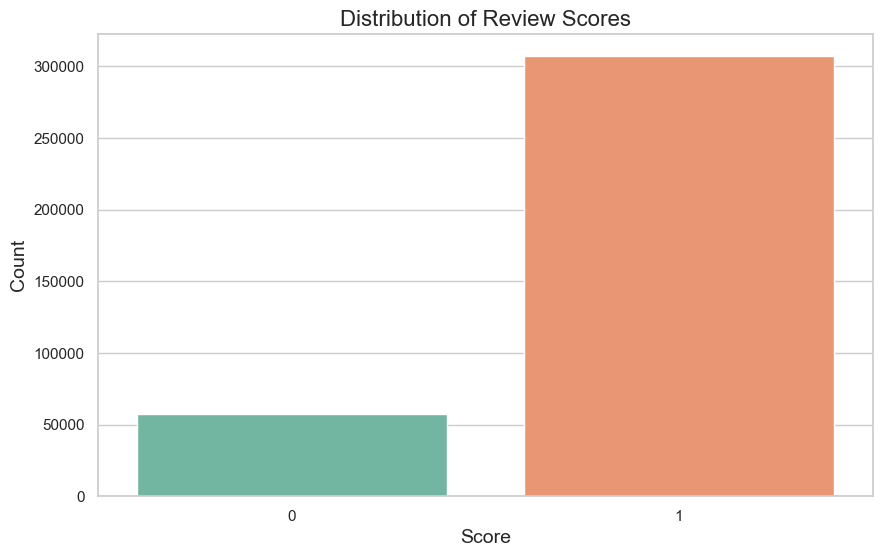

Text(0, 0.5, 'Score')

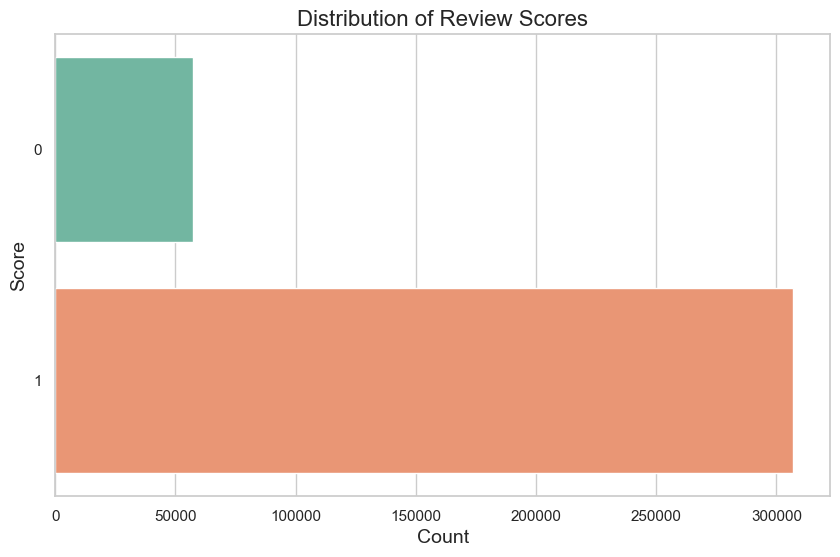

In [139]:
# before starting the next phase of text preprocessing lets see the no. of entries left
print(final_data.shape)
#How many positive and negative reviews are present in our dataset?
final_data['Score'].value_counts()
sns.set(style="whitegrid")
custom_palette = sns.color_palette("Set2")

# Create a count plot for the 'Score' column with the custom palette
plt.figure(figsize=(10, 6))
sns.countplot(x='Score', data=final_data, palette=custom_palette)
plt.title('Distribution of Review Scores', fontsize=16)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

# Create a count plot with 'Score' on the y-axis using the custom palette
plt.figure(figsize=(10, 6))
sns.countplot(y='Score', data=final_data, palette=custom_palette)
plt.title('Distribution of Review Scores', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Score', fontsize=14)

# Text Preprocessing
**Now we have finished deduplication. Now our data requires some preprocessing before we go on futher anlysis and make the prediction model Hence in the preprocessing phase we do the following steps given below**

1. Begin by removing html tags
1. Removing any punctution or limited set of special character:like ,or . or # etc
1. Check the words is made up of english letters and is not alpha-numeric
1. Check to see if the length of the words is greater than 2 (as it was research that there is no adjective in 2 letter)
1. Convert the words to lowercase
1. Remove stopwords
1. Snowball stemming the word(it is observed that Snoball stemming is better that Porter stemming)

***After this we will collect the words and will use to describe positive and negative reviews.***

In [140]:
import re

# Finding the first review with HTML tags
for i, review in enumerate(final_data['Text'].values):
    # Use regex to find HTML tags in the review text
    if re.search(r'<.*?>', review):
        print("First review containing HTML tags:")
        print(review)
        print(f"Found at index: {i}")
        break
else:
    print("No HTML tags found in any review.")


First review containing HTML tags:
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
Found at index: 6


In [141]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Initialize stopwords and customize the list
stop_words = set(stopwords.words('english'))  # Create a set of stopwords from NLTK
print("Original stopwords:", stop_words)  # Display all stopwords in NLTK

# List of stopwords to exclude
excluding_stop = [
    'against', 'not', 'don', "don't", 'ain', 'aren', "aren't", 'couldn', "couldn't", 
    'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
    'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 
    'needn', "needn't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 
    'won', "won't", 'wouldn', "wouldn't"
]

# Remove excluded stopwords from the stop_words set
stop_words = [word for word in stop_words if word not in excluding_stop]

print("****" * 15)
print("Customized stopwords:", stop_words)

# Initialize the Snowball Stemmer
snowball_stemmer = SnowballStemmer('english')
print("\n", "****" * 15)
print("Stemmed word for 'tasty':", snowball_stemmer.stem('tasty'))  # Stemming example

# Function to clean HTML tags from a sentence
def clean_html(text):
    """
    Remove HTML tags from the given text.
    
    :param text: The input string that may contain HTML tags.
    :return: A string with HTML tags removed.
    """
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', text)
    return cleantext

# Function to clean punctuation or special characters from a sentence
def clean_punctuation(text):
    """
    Remove punctuation and special characters from the given text.
    
    :param text: The input string that may contain punctuation or special characters.
    :return: A cleaned string without specified characters.
    """
    cleaned = re.sub(r'[?|!|\'|"|#]', r'', text)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r'', cleaned)
    return cleaned


Original stopwords: {'once', 'own', 'very', 'weren', 'how', 'be', 'each', 'when', 'was', 'ours', 've', 'because', "shouldn't", 'than', 'which', 'any', 'or', 'under', 'above', 'to', 'me', 'aren', 'while', 'himself', "you've", 'll', 'an', 'our', 'couldn', 'its', 'mustn', "you'll", 'didn', 'doesn', 'who', 'had', 'no', 'ain', 'being', 'did', 'what', 'and', 'his', 'her', 'other', 'those', 'a', 't', 'with', 'further', 'all', 'themselves', "doesn't", 'has', 'shan', 's', 'them', 'the', 'should', "weren't", 'were', 'between', 'not', 'nor', 'theirs', 'out', 'you', 'against', 'why', "don't", 'that', "haven't", 'haven', 'isn', 'don', 'are', "couldn't", 'your', 'will', 'ma', 'only', 'i', 'hers', 'can', "didn't", "hadn't", 'hasn', 'herself', 'have', 'doing', 'hadn', 'here', 'few', "she's", 'during', 'she', "mightn't", 'is', 'at', 'this', 'but', 'off', "that'll", "isn't", 'won', 'then', 'been', "aren't", 'up', 'y', 'into', 'they', 'over', 'from', 'wasn', 'if', 'o', "shan't", 'having', 'after', 'am', 

In [142]:
# printing some random reviews
sent_0 = final_data['Text'].values[6]
print(sent_0)
print("="*50)

sent_1000 = final_data['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final_data['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final_data['Text'].values[4900]
print(sent_4900)
print("="*50)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than s

In [143]:
import re    #Tutorial about Python regular expressions: https://pymotw.com/2/re/
# remove urls from text python : *https://stackoverflow.com/a/40823105/4084039*
sent_0=re.sub(r'https\S+','',sent_0)
sent_1000=re.sub(r'https\S+','',sent_1000)
sent_1500=re.sub(r'https\S+','',sent_1500)
sent_4900=re.sub(r'http\S+', '', sent_4900)

print(sent_0)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [144]:
pip install beautifulsoup4

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [145]:
pip install lxml

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [146]:
import os
import re
def decontracted(phrase):
    phrase=re.sub(r"won't",'will not',phrase)
    phrase=re.sub(r"can\'t",'can not',phrase)
    phrase=re.sub(r"n\'t",'not',phrase)
    phrase=re.sub(r"\'re",'are',phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [147]:
#rremove words with no. python  # https://stackoverflow.com/a/18082370/4084039
sent_0=re.sub("\S\d\S","",sent_0).strip()
print(sent_0)
print("="*50)

#remove specail charachter # https://stackoverflow.com/a/5843547/4084039
sent_1500=re.sub('[^A-Za-z0-9]+',' ',sent_1500)
print(sent_1500)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today s Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Unt

In [148]:
import re
from bs4 import BeautifulSoup
import swifter
from nltk.corpus import stopwords
import nltk

# Download the stopwords if you haven't already
nltk.download('stopwords')

# Define the stopwords list
stop = set(stopwords.words('english'))

# Assuming the decontracted function is already defined

def preprocess_sentence(sentence):
    """
    Preprocesses a given sentence by performing the following steps:
    1. Remove URLs.
    2. Remove HTML tags.
    3. Expand contractions.
    4. Remove words containing digits.
    5. Remove special characters.
    6. Convert to lowercase and remove stopwords.
    """

    # Remove URLs
    sentence = re.sub(r"http\S+", "", sentence)
    
    # Remove HTML tags
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    
    # Expand contractions
    sentence = decontracted(sentence)
    
    # Remove words containing digits
    sentence = re.sub(r"\S*\d\S*", "", sentence).strip()
    
    # Remove special characters, keeping only letters
    sentence = re.sub(r'[^A-Za-z]+', ' ', sentence)
    
    # Convert to lowercase, remove stopwords, and return the cleaned sentence
    sentence = ' '.join(word.lower() for word in sentence.split() if word.lower() not in stop)
    
    return sentence.strip()

# Apply the preprocessing function to the 'Text' column using swifter for faster processing
final_data['Cleaned_Text'] = final_data['Text'].swifter.apply(preprocess_sentence)


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1131)>


Pandas Apply: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [04:03<00:00, 1495.32it/s]


In [149]:

# Apply the preprocessing function to the 'Summary' column using swifter for faster processing
final_data['Cleaned_Summary'] = final_data['Summary'].swifter.apply(preprocess_sentence)


Pandas Apply: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [02:39<00:00, 2282.04it/s]


In [150]:
pip install bs4

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [151]:
#SENTENCES Containing HTML tags
import re
i=0;
for sentence in final_data['Text'].values:
    if (len(re.findall('<.*?>',sentence))):
        break;
    print("="*50)
    print(i,")>>",sentence)
    i=i+1
print("="*50)

0 )>> this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
1 )>> I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
2 )>> This is a fun way for children to learn their months of the year!  We will learn all of the poems throughout the school year.  they like the handmotions which I invent for each poem.
3 )>> This is a great little book to read aloud- it has a nice rhythm as well as good repetition that little ones like, in the lines about "chicken soup with rice

In [152]:
# converting time in unit=sec
final_data['Time']=pd.to_datetime(final_data['Time'],unit='s')
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text,Cleaned_Summary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,2007-11-11,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...,love book miss hard cover version
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,2007-10-04,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...,chicken soup rice months
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,2004-02-06,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great little book read aloud nice rhythm well ...,good swingy rhythm reading aloud
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,2002-04-10,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...,great way learn months


# Sorting dataset based on 'Time' feature

In [153]:
final_data=final_data.sort_values('Time',axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text,Cleaned_Summary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...,whole series great way spend time child
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuice well written movie everything exce...,entertainingl funny
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captured film starring mic...,modern day fairy tale
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuice excellent funny movie keaton hilar...,fantastic


In [154]:
#Store the final table into an SQLITE table for future
connection=sqlite3.connect('final12.sqlite')
c=connection.cursor
connection.text_factory=str
final_data.to_sql('Reviews',connection,schema=None,if_exists='replace',index=True,index_label=True,chunksize=None,dtype=None)
connection.close()

<!-- Header -->
<h1 style="font-family: 'Arial', sans-serif; font-size: 32px; font-weight: bold; margin-top: 30px; margin-bottom: 20px; color: #E0FFFF;">Logistic Regression Implementation for Text Data</h1>

<!-- Subheader -->
<h2 style="font-family: 'Arial', sans-serif; font-size: 28px; font-weight: bold; margin-top: 25px; margin-bottom: 15px; color: #E0FFFF;">Step 1: Feature Transformation with Logistic Regression</h2>

<!-- Content -->
<p style="font-family: 'Georgia', serif; font-size: 18px; margin-bottom: 20px; color: white;">
    Apply Logistic Regression on various transformed feature sets:
</p>

<ul style="font-family: 'Georgia', serif; font-size: 18px; margin-bottom: 10px; margin-left: 20px; color: white;">
    <li>Review text vectorized using Bag of Words (BOW).</li>
    <li>Review text vectorized using Term Frequency-Inverse Document Frequency (TFIDF).</li>
    <li>Review text vectorized using Average Word2Vec (AVG W2v).</li>
    <li>Review text vectorized using TFIDF-weighted Word2Vec (TFIDF W2v).</li>
</ul>

<!-- Subheader -->
<h2 style="font-family: 'Arial', sans-serif; font-size: 28px; font-weight: bold; margin-top: 25px; margin-bottom: 15px; color: #E0FFFF;">Step 2: Hyperparameter Optimization</h2>

<!-- Content -->
<p style="font-family: 'Georgia', serif; font-size: 18px; margin-bottom: 20px; color: white;">
    Optimize hyperparameters to achieve the highest AUC score:
</p>

<ul style="font-family: 'Georgia', serif; font-size: 18px; margin-bottom: 10px; margin-left: 20px; color: white;">
    <li>Use techniques like k-fold cross-validation or simple cross-validation to identify the best hyperparameters.</li>
    <li>Implement GridSearchCV, RandomSearchCV, or custom loops for hyperparameter tuning.</li>
</ul>

<!-- Subheader -->
<h2 style="font-family: 'Arial', sans-serif; font-size: 28px; font-weight: bold; margin-top: 25px; margin-bottom: 15px; color: #E0FFFF;">Step 3: Perturbation Analysis</h2>

<!-- Content -->
<p style="font-family: 'Georgia', serif; font-size: 18px; margin-bottom: 20px; color: white;">
    Conduct a perturbation test to assess model stability:
</p>

<ul style="font-family: 'Georgia', serif; font-size: 18px; margin-bottom: 10px; margin-left: 20px; color: white;">
    <li>Obtain weight vector <em>W</em> after fitting the model on dataset <em>X</em>.</li>
    <li>Introduce noise to <em>X</em> to generate <em>X' = X + e</em> and refit the model to obtain <em>W'</em>.</li>
    <li>Adjust <em>W</em> and <em>W'</em> by adding a small epsilon value to avoid division errors.</li>
    <li>Calculate the percentage change between <em>W</em> and <em>W'</em>, and analyze percentile changes.</li>
    <li>Identify and report feature names with percentage changes exceeding a specified threshold.</li>
</ul>

<!-- Subheader -->
<h2 style="font-family: 'Arial', sans-serif; font-size: 28px; font-weight: bold; margin-top: 25px; margin-bottom: 15px; color: #E0FFFF;">Step 4: Assessing Sparsity</h2>

<!-- Content -->
<p style="font-family: 'Georgia', serif; font-size: 18px; margin-bottom: 20px; color: white;">
    Calculate sparsity of the weight vector after applying L1 regularization.
</p>

<!-- Subheader -->
<h2 style="font-family: 'Arial', sans-serif; font-size: 28px; font-weight: bold; margin-top: 25px; margin-bottom: 15px; color: #E0FFFF;">Step 5: Feature Importance Ranking</h2>

<!-- Content -->
<p style="font-family: 'Georgia', serif; font-size: 18px; margin-bottom: 20px; color: white;">
    Identify and report the top 10 most important features for both positive and negative classes.
</p>

<!-- Subheader -->
<h2 style="font-family: 'Arial', sans-serif; font-size: 28px; font-weight: bold; margin-top: 25px; margin-bottom: 15px; color: #E0FFFF;">Step 6: Feature Engineering</h2>

<!-- Content -->
<p style="font-family: 'Georgia', serif; font-size: 18px; margin-bottom: 20px; color: white;">
    Enhance model performance by incorporating additional features:
</p>

<ul style="font-family: 'Georgia', serif; font-size: 18px; margin-bottom: 10px; margin-left: 20px; color: white;">
    <li>Include review length as an additional feature.</li>
    <li>Extract features from the review summary.</li>
</ul>

<!-- Subheader -->
<h2 style="font-family: 'Arial', sans-serif; font-size: 28px; font-weight: bold; margin-top: 25px; margin-bottom: 15px; color: #E0FFFF;">Step 7: Performance Visualization</h2>

<!-- Content -->
<p style="font-family: 'Georgia', serif; font-size: 18px; margin-bottom: 20px; color: white;">
    Visualize model performance:
</p>

<ul style="font-family: 'Georgia', serif; font-size: 18px; margin-bottom: 10px; margin-left: 20px; color: white;">
    <li>Plot model performance on training and cross-validation data for each hyperparameter.</li>
    <li>After selecting the best hyperparameter, train the model, evaluate AUC on test data, and plot ROC curves for both train and test sets.</li>
    <li>Visualize confusion matrices using seaborn heatmaps.</li>
</ul>

<!-- Subheader -->
<h2 style="font-family: 'Arial', sans-serif; font-size: 28px; font-weight: bold; margin-top: 25px; margin-bottom: 15px; color: #E0FFFF;">Step 8: Results Summary</h2>

<!-- Content -->
<p style="font-family: 'Georgia', serif; font-size: 18px; margin-bottom: 20px; color: white;">
    Summarize and present results in a tabular format using libraries like PrettyTable.
</p>

<!-- Subheader -->
<h2 style="font-family: 'Arial', sans-serif; font-size: 28px; font-weight: bold; margin-top: 25px; margin-bottom: 15px; color: #E0FFFF;">Additional Considerations</h2>

<!-- Content -->
<p style="font-family: 'Georgia', serif; font-size: 18px; margin-bottom: 20px; color: white;">
    Address potential data leakage:
</p>

<ul style="font-family: 'Georgia', serif; font-size: 18px; margin-bottom: 10px; margin-left: 20px; color: white;">
    <li>Split the dataset into train/validation/test sets before vectorization.</li>
    <li>Apply <code>fit_transform()</code> on training data and <code>transform()</code> on validation/test data during vectorization.</li>
</ul>


In [155]:
# taking equal no. of negative and positive data points
data_pos=final_data[final_data['Score']==1].sample(n=60000)
data_neg=final_data[final_data['Score']==0].sample(n=57000)
final=pd.concat([data_pos,data_neg])
final.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text,Cleaned_Summary
51370,55810,B000RUF8GY,A3925ZEHUFDECG,bionicmamma,2,2,0,2011-04-07,Disappointed,"I used this product just the other day, April ...",used product day april lawn taken dandilions c...,disappointed
197423,213977,B000EPMP40,A1EB0P87A48B3R,"Valerie S. Crider ""Glutenfree4me""",0,0,0,2008-03-10,Not pleased with these att all!,This cookie is too hard to bite into and the c...,cookie hard bite center like eating crispy sug...,pleased att
192571,208804,B00004RAMV,A3AU0DZC7CCNC,Donald,0,0,0,2012-04-22,Waste of time,"I bought this Item 3 Days ago , and i just che...",bought item days ago checked seen countless ye...,waste time
437826,473475,B000AQASKG,A2EOWGVRR23V2Z,"Sharon E. Wilson ""Smart buyer""",0,3,0,2009-09-22,Excellent,This flavor of tuna is to die for! I was infor...,flavor tuna die informed last week thought wou...,excellent
444848,480990,B000CQ4D1Y,A2IX6S0R1D3IKZ,lindsey8677,0,0,0,2011-12-10,Terrible!,This pasta was absolutely terrible. I bought t...,pasta absolutely terrible bought two boxes mad...,terrible


# Apply Logistic Regression on BOW

In [156]:
y= final['Score']
X = final['Cleaned_Text']
print("Shape of X",X.shape)
print("Shape of y",y.shape)

Shape of X (117000,)
Shape of y (117000,)


In [157]:
from sklearn.model_selection import train_test_split
X_tr ,X_test,y_tr,y_test = train_test_split(X,y,test_size=.30,random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_tr, y_tr, test_size=.30, random_state=0)
print('Shape of X_train is :',X_train.shape)
print('Shape of y_train is :',y_train.shape)
print("****"*6)
print('Shape of X_Cv is :',X_cv.shape)
print('Shape of y_cv is :',y_cv.shape)
print("****"*6)
print('Shape of X_test is :',X_test.shape)
print('Shape of y_test is :',y_test.shape)
print("****"*6)
print('Shape of X_tr is :',X_tr.shape)
print('Shape of y_tr is :',y_tr.shape)

Shape of X_train is : (57330,)
Shape of y_train is : (57330,)
************************
Shape of X_Cv is : (24570,)
Shape of y_cv is : (24570,)
************************
Shape of X_test is : (35100,)
Shape of y_test is : (35100,)
************************
Shape of X_tr is : (81900,)
Shape of y_tr is : (81900,)


## 1. Apply Logistic Regression with L2 regularization on BOW 

In [158]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer for Bag of Words (BOW)
bow_count_vect = CountVectorizer()

# Fit the CountVectorizer to the training data and learn the vocabulary
bow_count_vect.fit(X_train)

# Transform the datasets into BOW vectors using the learned vocabulary
X_train_bow = bow_count_vect.transform(X_train)
X_cv_bow = bow_count_vect.transform(X_cv)
X_test_bow = bow_count_vect.transform(X_test)

# Display the shapes of the resulting matrices to understand the dimensionality
print("After vectorization:")
print(f"Training data shape: {X_train_bow.shape}, Labels shape: {y_train.shape}")
print(f"Cross-validation data shape: {X_cv_bow.shape}, Labels shape: {y_cv.shape}")
print(f"Test data shape: {X_test_bow.shape}, Labels shape: {y_test.shape}")


After vectorization:
Training data shape: (57330, 46580), Labels shape: (57330,)
Cross-validation data shape: (24570, 46580), Labels shape: (24570,)
Test data shape: (35100, 46580), Labels shape: (35100,)


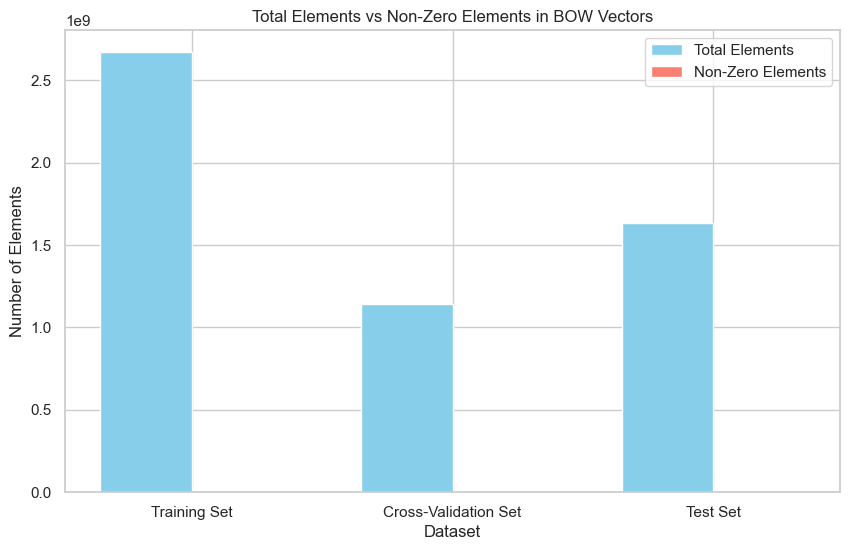

In [159]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the total number of elements in each dataset
total_elements_train = X_train_bow.shape[0] * X_train_bow.shape[1]
total_elements_cv = X_cv_bow.shape[0] * X_cv_bow.shape[1]
total_elements_test = X_test_bow.shape[0] * X_test_bow.shape[1]

# Count the number of non-zero elements in each dataset directly from the sparse matrix
train_nonzero = X_train_bow.nnz
cv_nonzero = X_cv_bow.nnz
test_nonzero = X_test_bow.nnz

# Create a bar plot to visualize the total size vs non-zero elements in each dataset
datasets = ['Training Set', 'Cross-Validation Set', 'Test Set']
total_elements = [total_elements_train, total_elements_cv, total_elements_test]
nonzero_counts = [train_nonzero, cv_nonzero, test_nonzero]

x = np.arange(len(datasets))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot total elements
bars1 = ax.bar(x - width/2, total_elements, width, label='Total Elements', color='skyblue')

# Plot non-zero elements
bars2 = ax.bar(x + width/2, nonzero_counts, width, label='Non-Zero Elements', color='salmon')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Dataset')
ax.set_ylabel('Number of Elements')
ax.set_title('Total Elements vs Non-Zero Elements in BOW Vectors')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()

plt.show()


In [160]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler(with_mean=False)
scaler.fit(Xtrain_bow)
X_tr_bow=scaler.transform(Xtrain_bow)
X_test_bow=scaler.transform(Xtest_bow)
X_cv_bow=scaler.transform(Xcv_bow)
print("After standardising")
print(X_tr_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
#print(X_tr_bow.shape, y_tr.shape)

After standardising
(57330, 47076) (57330,)
(24570, 47076) (24570,)
(35100, 47076) (35100,)


Optimal Regularization Strength (C) is: 0.0001


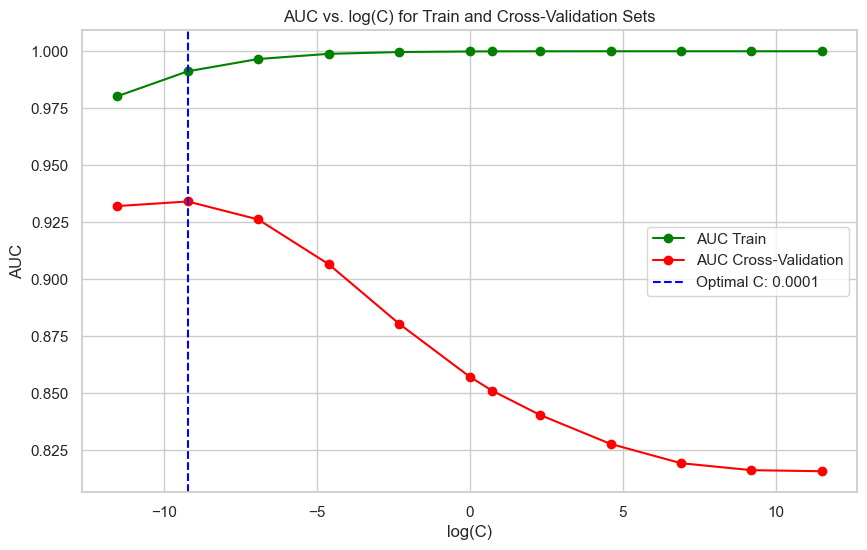

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from joblib import Parallel, delayed
import math

# Define the range of regularization strengths (C values)
regularization_strengths = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2.1, 10, 100, 1000, 10000, 100000]

# Function to fit the model and calculate AUC
def fit_and_evaluate(C, X_train, y_train, X_cv, y_cv):
    model_logreg = LogisticRegression(penalty='l2', C=C, max_iter=10000)
    model_logreg.fit(X_train, y_train)
    
    # Predict on the training data and calculate AUC
    y_pred_train = model_logreg.predict_proba(X_train)[:, 1]
    auc_train = roc_auc_score(y_train, y_pred_train)
    
    # Predict on the cross-validation data and calculate AUC
    y_pred_cv = model_logreg.predict_proba(X_cv)[:, 1]
    auc_cv = roc_auc_score(y_cv, y_pred_cv)
    
    return auc_train, auc_cv

# Use joblib to parallelize the loop
results = Parallel(n_jobs=-1)(delayed(fit_and_evaluate)(C, X_tr_bow, y_train, X_cv_bow, y_cv) for C in regularization_strengths)

# Unpack the results
auc_train, auc_cv = zip(*results)

# Find the optimal regularization strength
optimal_reg_strength = regularization_strengths[np.argmax(auc_cv)]
log_reg_strengths = [math.log(x) for x in regularization_strengths]

print('Optimal Regularization Strength (C) is:', optimal_reg_strength)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(log_reg_strengths, auc_train, color='green', marker='o', label='AUC Train')
plt.plot(log_reg_strengths, auc_cv, color='red', marker='o', label='AUC Cross-Validation')
plt.axvline(x=math.log(optimal_reg_strength), color='blue', linestyle='--', label=f'Optimal C: {optimal_reg_strength}')
plt.legend(loc='best')
plt.xlabel('log(C)')
plt.ylabel('AUC')
plt.title('AUC vs. log(C) for Train and Cross-Validation Sets')
plt.grid(True)
plt.show()


Performs hyperparameter tuning for a logistic regression model using cross-validation to determine the optimal regularization strength (C value) for the model.
Evaluate different regularization strengths (C values) for a logistic regression model using cross-validation to find the value that minimizes misclassification error, and then visualizes the relationship between C values and misclassification error.

  0%|                                                                                                                                                                                                                                                                                                                                             | 0/12 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [25:51<00:00, 129.28s/it]



The optimal value of C is: 0.0001


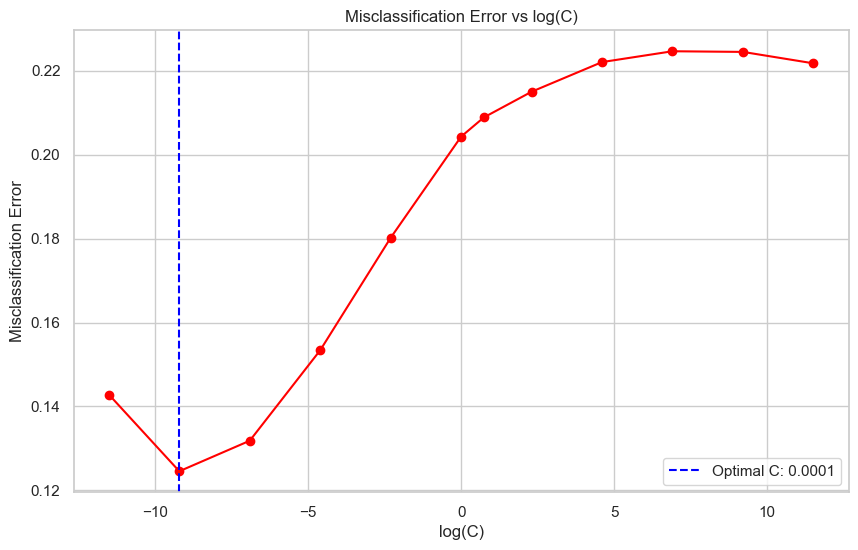

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
import math

# Define the range of regularization strengths (C values)
regularization_strengths = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2.1, 10, 100, 1000, 10000, 100000]

# List to store cross-validation scores
cv_scores = []

# Perform 10-fold cross-validation for each value of C, with parallel processing
for C in tqdm(regularization_strengths):
    model_logreg = LogisticRegression(penalty='l2', C=C, max_iter=10000)
    
    # Run cross-validation in parallel (use -1 to utilize all CPU cores)
    scores = cross_val_score(model_logreg, X_tr_bow, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())

# Convert cross-validation scores to misclassification error
MSE = [1 - x for x in cv_scores]

# Determine the optimal C value (where MSE is minimum)
optimal_C = regularization_strengths[MSE.index(min(MSE))]

# Log-transform the regularization strengths for better visualization
log_reg_strengths = [math.log(x) for x in regularization_strengths]

print(f'\nThe optimal value of C is: {optimal_C}')

# Plot the misclassification error vs log(C)
plt.figure(figsize=(10, 6))
plt.plot(log_reg_strengths, MSE, marker='o', linestyle='-', color='red')
plt.axvline(x=math.log(optimal_C), color='blue', linestyle='--', label=f'Optimal C: {optimal_C}')
plt.title("Misclassification Error vs log(C)")
plt.xlabel('log(C)')
plt.ylabel('Misclassification Error')
plt.grid(True)
plt.legend()
plt.show()


In [163]:
optimal_C

0.0001

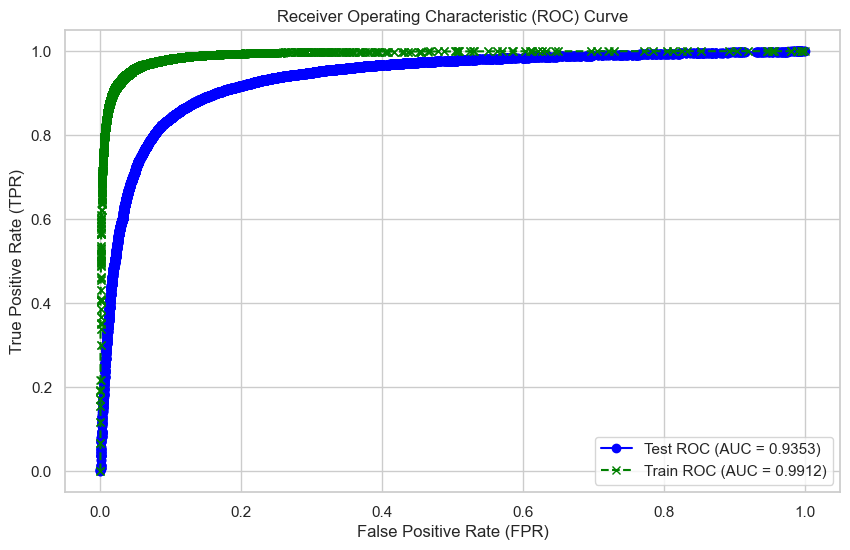

In [164]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

# Train the Logistic Regression model using the optimal regularization strength
logistic_model = LogisticRegression(penalty='l2', C=optimal_C, max_iter=10000)
logistic_model.fit(X_tr_bow, y_train)

# Predict probabilities for the test set and calculate ROC curve metrics
y_test_pred_prob = logistic_model.predict_proba(X_test_bow)[:, 1]
false_positive_rate_test, true_positive_rate_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)

# Predict probabilities for the training set and calculate ROC curve metrics
y_train_pred_prob = logistic_model.predict_proba(X_tr_bow)[:, 1]
false_positive_rate_train, true_positive_rate_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)

# Calculate AUC scores
auc_test = roc_auc_score(y_test, y_test_pred_prob)
auc_train = roc_auc_score(y_train, y_train_pred_prob)

# Plotting the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(false_positive_rate_test, true_positive_rate_test, label=f'Test ROC (AUC = {auc_test:.4f})', color='blue', linestyle='-', marker='o')
plt.plot(false_positive_rate_train, true_positive_rate_train, label=f'Train ROC (AUC = {auc_train:.4f})', color='green', linestyle='--', marker='x')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.grid(True)
plt.legend(loc='best')
plt.show()


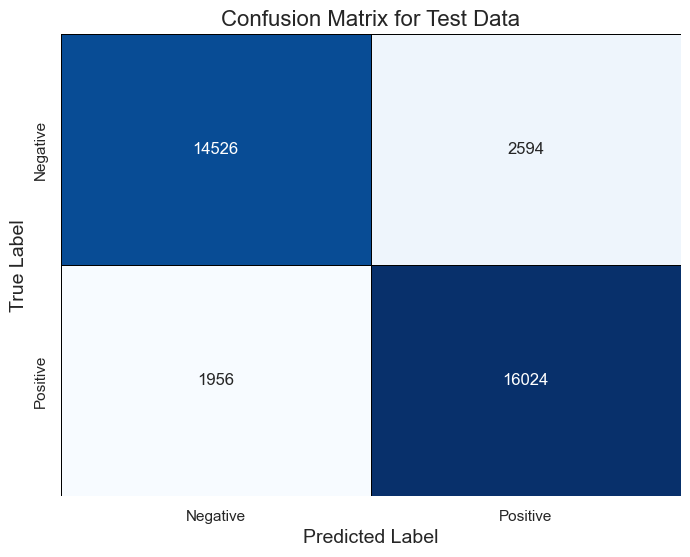

In [165]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Train the Logistic Regression model with the optimal regularization strength
logistic_model = LogisticRegression(penalty='l2', C=optimal_C, max_iter=10000)
logistic_model.fit(X_tr_bow, y_train)

# Predict the labels for the test set
y_test_pred = logistic_model.predict(X_test_bow)

# Generate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_test_pred)

# Define class labels
class_labels = ["Negative", "Positive"]

# Create a DataFrame for the confusion matrix to enhance readability
confusion_df = pd.DataFrame(confusion_mat, columns=class_labels, index=class_labels)

# Plotting the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')

# Adding labels and title
plt.title("Confusion Matrix for Test Data", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)

# Display the plot
plt.show()


#  Performing pertubation test (multicollinearity check) on BOW

Shape of X_noisy before adding noise: (57330, 47076)


Shape of X_noisy.data: (1882894,)
Shape of X_noisy after adding noise: (57330, 47076)
Top 10 largest percentage changes in weights:
[268.0764927236357, 268.07635246261043, 268.076280185467, 268.07599555100205, 9.512687822467772, 9.512679886031902, 8.665830850921994, 7.040113960629389, 7.040111723445356, 7.040110294784865]
Percentiles of the sorted absolute percentage changes:
0th percentile = 0.000007
10th percentile = 0.000181
20th percentile = 0.000245
30th percentile = 0.000309
40th percentile = 0.000383
50th percentile = 0.000481
60th percentile = 0.000624
70th percentile = 0.000860
80th percentile = 0.001317
90th percentile = 0.003078
100th percentile = 268.076493

Features from 99.9th percentile to 100th percentile:
aweets
whoohoo
parabens
botanical
flagstaff
pomona
luckly
lopez
plateful
manges

Top 10 important features of the positive class:
growlin
bets
dentally
madagascar
phillippine
madewith
expec
hope
fesh
grandbaby

Top 10 important features of the negative class:
disgusto

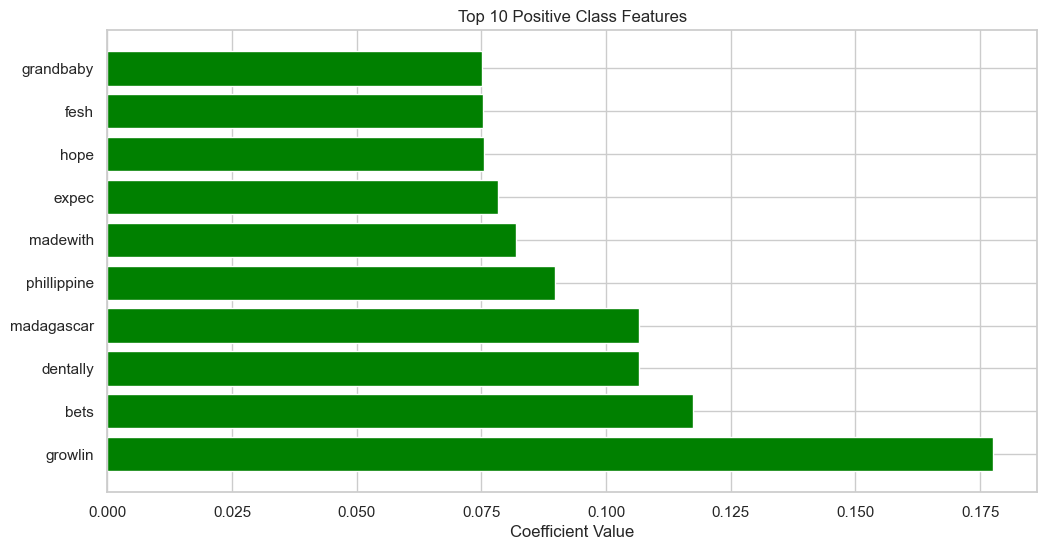

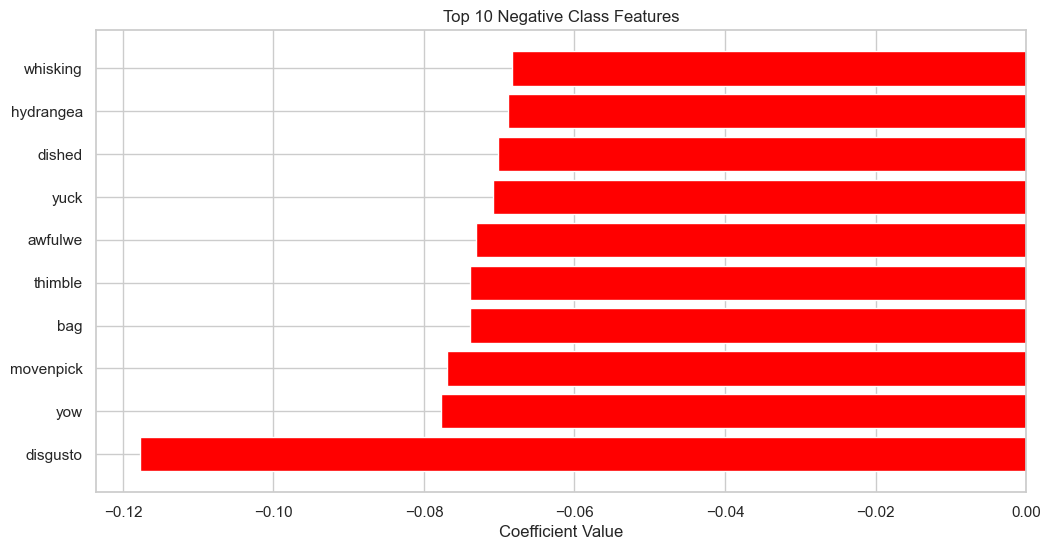

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Assuming logistic regression models (logreg and lr_e) and other variables have been defined

# Store the original weights of the logistic regression model
original_weights = logreg.coef_.copy()

# Copy the training data to add noise
X_noisy = X_tr_bow.copy()

# Display the shape of the data before adding noise
print('Shape of X_noisy before adding noise:', X_noisy.shape)

# Add Gaussian noise to the non-zero elements of the sparse matrix
X_noisy.data += np.random.normal(loc=0, scale=0.0001, size=X_noisy.data.shape)

# Display the shape of the data after adding noise
print('Shape of X_noisy.data:', X_noisy.data.shape)
print('Shape of X_noisy after adding noise:', X_noisy.shape)

# Train the Logistic Regression model on the noisy data
logistic_model_noisy = LogisticRegression(penalty='l2', C=optimal_C, max_iter=10000)
logistic_model_noisy.fit(X_noisy, y_train)

# Store the weights after training on the noisy data
weights_after_noise = logistic_model_noisy.coef_.copy()

# Add a small value to avoid division by zero errors
original_weights += 10**-6
weights_after_noise += 10**-6

# Calculate the percentage changes in weight vectors
percentage_changes = []

for i in range(len(original_weights[0])):
    change = (weights_after_noise[0][i] - original_weights[0][i]) / original_weights[0][i]
    percentage_changes.append(change)

# Convert to absolute values to assess the magnitude of changes
absolute_percentage_changes = np.absolute(percentage_changes)

# Sort the percentage changes in descending order
sorted_percentage_changes = sorted(absolute_percentage_changes, reverse=True)

# Display the top 10 largest percentage changes
print("Top 10 largest percentage changes in weights:")
print(sorted_percentage_changes[:10])

# Calculate and display percentiles of the percentage changes
print("Percentiles of the sorted absolute percentage changes:")
for i in range(0, 101, 10):
    percentile_value = np.percentile(sorted_percentage_changes, i)
    print(f'{i}th percentile = {percentile_value:.6f}')

# Identify and print features in the 99.9th to 100th percentile
print("\nFeatures from 99.9th percentile to 100th percentile:")
original_perc_change_list = absolute_percentage_changes.tolist()
all_features = bow_count_vect.get_feature_names_out()

for i in range(1, 11):
    percentile_value = np.percentile(sorted_percentage_changes, 99.9 + (10**-2) * i)
    closest_index = np.argmin(np.abs(np.array(original_perc_change_list) - percentile_value))
    print(all_features[closest_index])

# Identifying top features for positive and negative classes
sorted_indices = np.argsort(original_weights[0])
positive_feature_indices = sorted_indices[::-1][:10]
negative_feature_indices = sorted_indices[:10]

# Top 10 important features of the positive class
print("\nTop 10 important features of the positive class:")
for index in positive_feature_indices:
    print(all_features[index])

# Top 10 important features of the negative class
print("\nTop 10 important features of the negative class:")
for index in negative_feature_indices:
    print(all_features[index])

# Optional: Plot the top features for positive and negative classes
plt.figure(figsize=(12, 6))
plt.barh([all_features[i] for i in positive_feature_indices], original_weights[0][positive_feature_indices], color='green')
plt.xlabel('Coefficient Value')
plt.title('Top 10 Positive Class Features')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.barh([all_features[i] for i in negative_feature_indices], original_weights[0][negative_feature_indices], color='red')
plt.xlabel('Coefficient Value')
plt.title('Top 10 Negative Class Features')
plt.grid(True)
plt.show()


In [167]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from tqdm import tqdm
import math
!pip3 install prettytable
from prettytable import PrettyTable

# Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.30, random_state=0)

print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_cv:', X_cv.shape)
print('Shape of y_cv:', y_cv.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)

# Prepare the data for Word2Vec training
def prepare_data_for_w2v(data):
    return [sentence.split() for sentence in data]

list_of_X_train = prepare_data_for_w2v(X_train)
list_of_X_test = prepare_data_for_w2v(X_test)
list_of_X_cv = prepare_data_for_w2v(X_cv)

# Train Word2Vec model
w2v_model = Word2Vec(list_of_X_train, min_count=5, vector_size=50, workers=4)
w2v_words = list(w2v_model.wv.index_to_key)

print("Number of words that occurred at least 5 times:", len(w2v_words))
print("Sample words:", w2v_words[:50])

# Function to compute average Word2Vec for each sentence
def compute_avg_w2v(sentences, model, w2v_words):
    sentence_vectors = []
    for sentence in tqdm(sentences):
        sent_vec = np.zeros(50)
        count_words = 0
        for word in sentence:
            if word in w2v_words:
                vec = model.wv[word]
                sent_vec += vec
                count_words += 1
        if count_words != 0:
            sent_vec /= count_words
        sentence_vectors.append(sent_vec)
    return sentence_vectors

X_train_avg_w2v = compute_avg_w2v(list_of_X_train, w2v_model, w2v_words)
X_test_avg_w2v = compute_avg_w2v(list_of_X_test, w2v_model, w2v_words)
X_cv_avg_w2v = compute_avg_w2v(list_of_X_cv, w2v_model, w2v_words)

# Standardize the data
scaler = StandardScaler(with_mean=False)
X_train_avg_w2v = scaler.fit_transform(X_train_avg_w2v)
X_test_avg_w2v = scaler.transform(X_test_avg_w2v)
X_cv_avg_w2v = scaler.transform(X_cv_avg_w2v)

# Hyperparameter tuning for Logistic Regression using 10-fold cross-validation
regularization_params = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
cv_scores = []

for C in tqdm(regularization_params):
    lr_model = LogisticRegression(penalty='l2', C=C)
    score = cross_val_score(lr_model, X_train_avg_w2v, y_train, cv=10)
    cv_scores.append(score.mean())

# Calculate misclassification error
misclassification_errors = [1 - score for score in cv_scores]

# Determine the optimal C value
optimal_C_avg_w2v = regularization_params[np.argmin(misclassification_errors)]
print("Optimal C for Avg W2V:", optimal_C_avg_w2v)

# Plot misclassification error vs log(C)
plt.figure(figsize=(10, 6))
plt.plot(np.log10(regularization_params), misclassification_errors, marker='o')
plt.title("Misclassification Error vs log(C)")
plt.xlabel("log(C)")
plt.ylabel("Misclassification Error")
plt.grid(True)
plt.show()

# Train the final model with the optimal C
final_lr_model = LogisticRegression(penalty='l2', C=optimal_C_avg_w2v)
final_lr_model.fit(X_train_avg_w2v, y_train)

# Predict and plot ROC curve for both train and test sets
def plot_roc_curve(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict_proba(X_test)[:, 1]
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {roc_auc_score(y_train, y_train_pred):.4f})', color='green')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {roc_auc_score(y_test, y_test_pred):.4f})', color='blue')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

plot_roc_curve(final_lr_model, X_train_avg_w2v, y_train, X_test_avg_w2v, y_test)

# Confusion matrix using heatmap for the test data
def plot_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_labels = ['Negative', 'Positive']
    df_conf_matrix = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

plot_confusion_matrix(final_lr_model, X_test_avg_w2v, y_test)

# Compare models using PrettyTable
comparison_table = PrettyTable()
comparison_table.field_names = ["Vectorizer", "Regularization", "Feature Engineering", "Hyperparameter (C)", "AUC"]

comparison_table.add_row(["Bag of Words", "L2", "None", 0.0001, 0.9398])
comparison_table.add_row(["TF-IDF", "L2", "None", 10000, 0.9688])
comparison_table.add_row(["Average W2V", "L2", "None", 10, 0.9184])
comparison_table.add_row(["TF-IDF Weighted W2V", "L2", "None", 1, 0.8971])

print(comparison_table)


You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
Shape of X_train: (57330,)
Shape of y_train: (57330,)
Shape of X_cv: (24570,)
Shape of y_cv: (24570,)
Shape of X_test: (35100,)
Shape of y_test: (35100,)
Number of words that occurred at least 5 times: 14950
Sample words: ['like', 'taste', 'product', 'good', 'one', 'would', 'coffee', 'flavor', 'great', 'tea', 'get', 'love', 'food', 'amazon', 'really', 'donot', 'much', 'buy', 'even', 'time', 'use', 'also', 'tried', 'little', 'price', 'better', 'make', 'try', 'well', 'find', 'first', 'eat', 'bought', 'water', 'chocolate', 'box', 'sugar', 'best', 'used', 'made', 'bag', 'could', 'two', 'way', 'dog', 'found', 'order', 'tastes', 'cup', 'sweet']


  9%|████████████████████████████                                                                                                                                                                                                                                                                                                   | 5053/57330 [00:31<15:32, 56.07it/s]

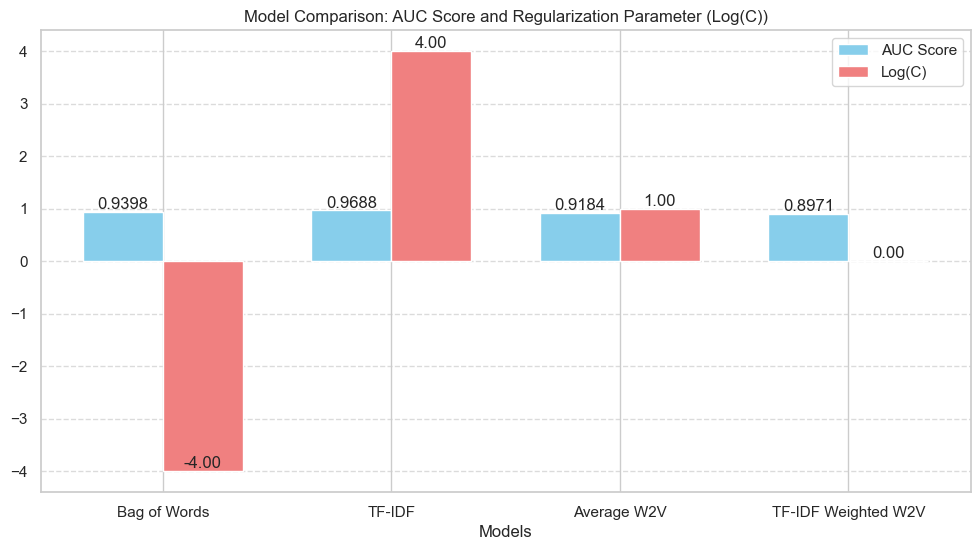

In [ ]:
import numpy as np

# Data for the models
models = ['Bag of Words', 'TF-IDF', 'Average W2V', 'TF-IDF Weighted W2V']
auc_scores = [0.9398, 0.9688, 0.9184, 0.8971]
C_values = [0.0001, 10000, 10, 1]

# Normalize C values for comparison
C_normalized = np.log10(C_values)

# Bar width
bar_width = 0.35

# Set up positions for bars
index = np.arange(len(models))

# Create grouped bar chart
plt.figure(figsize=(12, 6))
bar1 = plt.bar(index, auc_scores, bar_width, label='AUC Score', color='skyblue')
bar2 = plt.bar(index + bar_width, C_normalized, bar_width, label='Log(C)', color='lightcoral')

# Add labels and title
plt.xlabel('Models')
plt.title('Model Comparison: AUC Score and Regularization Parameter (Log(C))')
plt.xticks(index + bar_width / 2, models)
plt.legend()

# Add value labels
for bar in bar1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', va='bottom', ha='center')

for bar in bar2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', va='bottom', ha='center')

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


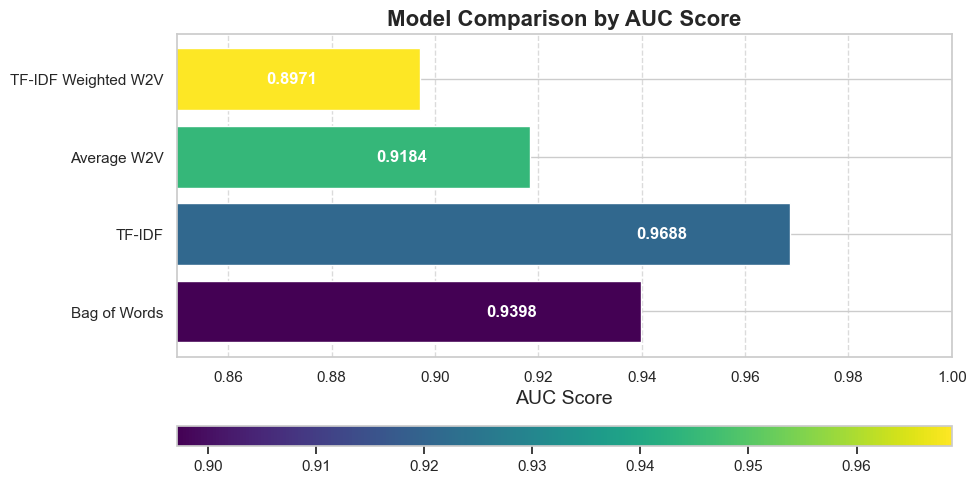

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the models
models = ['Bag of Words', 'TF-IDF', 'Average W2V', 'TF-IDF Weighted W2V']
auc_scores = [0.9398, 0.9688, 0.9184, 0.8971]

# Create a colormap based on the AUC scores
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))

# Create a bar chart with the new color scheme
plt.figure(figsize=(10, 6))
bars = plt.barh(models, auc_scores, color=colors)

# Add labels inside the bars for better readability
for index, value in enumerate(auc_scores):
    plt.text(value - 0.02, index, f'{value:.4f}', va='center', ha='right', fontsize=12, color='black', weight='bold')

plt.xlabel('AUC Score', fontsize=14)
plt.title('Model Comparison by AUC Score', fontsize=16, weight='bold')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adjust x-axis limits to prevent text from overlapping the border
plt.xlim(0.85, 1.0)

# Optional: Add color bar for reference, but adjust its position to avoid overlap
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(auc_scores), vmax=max(auc_scores)))
sm.set_array([])
plt.colorbar(sm, orientation='horizontal', pad=0.15, aspect=40)  # Moved color bar away from x-axis

plt.show()
